<a href="https://colab.research.google.com/github/CassDabii/BBC-DS-Task/blob/main/Copy_of_BBC_DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***BBC Data Science Project*** 
---
Since this project is open-ended, it is up to me to determine what data is useful to make actionable insights. To do this I will make a list of preliminary goals that are variable; however, any goals added or omitted will not be hidden but instead justified to maintain credibility




Goals
*   Determine the effect weather has on the length of the journey and the cycle volume.
*   Determine the usefulness and performance of trying to predict cycle volumes
*   Decipher where to add another station











## Acquiring Data

In [41]:
# All imports declared at top cell to have a centralised location if changes are needed
import pandas as pd
import matplotlib.pyplot  as plt
%matplotlib inline
import numpy as np
import sqlite3 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Connects to my uploaded database and creates a cursor object to execute SQL statements when needed
conn = sqlite3.connect('/content/BBCDS.sqlite3')

In [3]:
# Reads the database tables and writes it into a dataframe
bike_journeys = pd.read_sql('SELECT * FROM bike_journeys;',conn)
bike_stations = pd.read_sql('SELECT * FROM bike_stations;',conn)
weather = pd.read_sql('SELECT * FROM weather;',conn)

### Bike Journeys

In [4]:
# Shows the data in a dataframe format
bike_journeys.head()

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
0,2040,953,19,9,17,18,0,478,19,9,17,17,26,251
1,1800,12581,19,9,17,15,21,122,19,9,17,14,51,550
2,1140,1159,15,9,17,17,1,639,15,9,17,16,42,212
3,420,2375,14,9,17,12,16,755,14,9,17,12,9,163
4,1200,14659,13,9,17,19,33,605,13,9,17,19,13,36


Looking over the data, the lowest change in the time series is minutes: However, cross-referencing with the other columns shows that the journey duration is given in seconds, so that will have to be changed since that inconsistency lowers the data quality. I also see that some journeys have the same ID, so its purpose as a primary key has failed. My initial thoughts are that the data needs a lot of TLC and quality is low due to over use of columns for date and time and no Primary Key.




In [5]:
bike_journeys.shape

(1542844, 14)

### Bike Stations

In [6]:
bike_stations.head()

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


I can already see that the Station ID can be a foreign key between bike stations and bike journeys. I am expecting to use a join to get all the data in one flat table.

In [7]:
bike_stations.shape

(773, 5)

### Weather

In [8]:
weather.head()

,LATITUDE,LONGITUDE,DATE,PRCP (MM),TAVG (CELSIUS)
0,51.478,-0.461,01/08/2017,0.0,17.1
1,51.478,-0.461,02/08/2017,0.8,16.8
2,51.478,-0.461,03/08/2017,7.1,18.4
3,51.478,-0.461,04/08/2017,0.0,18.3
4,51.478,-0.461,05/08/2017,0.0,16.8


The way the date is formatted in this dataset differs from the bike journeys data set so this will have to be changed so I can join these datasets. Also, this data only tells the average temperature and precipitation, which will likley lower the correlation that weather conditions have with the journey duration and other features.

In [9]:
weather.shape

(44, 5)

## Data Preparation

In [10]:
# The use of these 2 methods together checks if there are missing values in any of the columns
bike_journeys.isnull().any() 

Journey Duration    False
Journey ID          False
End Date            False
End Month           False
End Year            False
End Hour            False
End Minute          False
End Station ID      False
Start Date          False
Start Month         False
Start Year          False
Start Hour          False
Start Minute        False
Start Station ID    False
dtype: bool

Initially, I want to check if there is any missing data in any of the columns since it could most probably be lowering the data quality. However, other alternatives to just dropping rows of data could be looked into. Depending on factors such as where the missing data lies (e.g., if the station ID's are missing, that is a major factor for the outcomes, but if the start hour is missing but there is still the journey duration). The data could be filled, this also depends on how much missing data there is, could tell me if it worth going through these changes.

In [11]:
bike_stations.isnull().any()

Station ID      False
Capacity        False
Latitude        False
Longitude       False
Station Name    False
dtype: bool

In [12]:
weather.isnull().any()

LATITUDE          False
LONGITUDE         False
DATE              False
PRCP (MM)         False
TAVG (CELSIUS)    False
dtype: bool

I want to join all the datasets to have all the data in one flat table so I can use statistical and visualization methods seamlessly. I know that to join the bike stations and journey ID i can join them through the station ID's. The weather dataset does not have an explicit column I can use to join. A merge using pandas is possible, but the query flexibility and speed of SQL joins will be more useful in the circumstances.

I write an SQL script in the sqlite3 interface that turns the date columns into the date format DD/MM/YYYY and drop the columns that are now unnecessary. Also, if I am formatting the date it would make the data more clean to format the times also.



**Adds the columns to the table**
```
ALTER TABLE bike_journeys_formatted ADD COLUMN formatted_start_date TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN formatted_end_date TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN start_time TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN end_time TEXT;
```



**This uses the columns to make the date in the DD/MM/YYYY format and if the month or date is a single character it adds 0 to the front. 2000 is added to the year to fit the format.**
```
UPDATE bike_journeys_formatted
SET formatted_start_date = CASE
  WHEN LENGTH("Start Date") = 1 AND LENGTH("Start Month") = 1 THEN '0'||"Start Date"||'/0'||"Start Month"||'/'||("Start Year"+2000)
  WHEN LENGTH("Start Date") = 1 THEN '0'||"Start Date"||'/'||"Start Month"||'/'||("Start Year"+2000)
  WHEN LENGTH("Start Month") = 1 THEN "Start Date"||'/0'||"Start Month"||'/'||("Start Year"+2000)
  ELSE "Start Date"||'/'||"Start Month"||'/'||("Start Year"+2000)
END,
formatted_end_date = CASE
  WHEN LENGTH("End Date") = 1 AND LENGTH("End Month") = 1 THEN '0'||"End Date"||'/0'||"End Month"||'/'||("End Year"+2000)
  WHEN LENGTH("End Date") = 1 THEN '0'||"End Date"||'/'||"End Month"||'/'||("End Year"+2000)
  WHEN LENGTH("End Month") = 1 THEN "End Date"||'/0'||"End Month"||'/'||("End Year"+2000)
  ELSE "End Date"||'/'||"End Month"||'/'||("End Year"+2000)
END;

```
**The times are formatted to HH:MM using the respective Hour and Minute columns**



```
# UPDATE bike_journeys_formatted
SET end_time = CASE
                WHEN "End Hour" < 10 THEN '0'||"End Hour"
                ELSE "End Hour"
              END
              || ':'
              || CASE
                   WHEN "End Minute" < 10 THEN '0'||"End Minute"
                   ELSE "End Minute"
                 END,
    start_time = CASE
                  WHEN "Start Hour" < 10 THEN '0'||"Start Hour"
                  ELSE "Start Hour"
                END
                || ':'
                || CASE
                     WHEN "Start Minute" < 10 THEN '0'||"Start Minute"
                     ELSE "Start Minute"
                   END;
```







**Then the old columns are dropped**

```
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Date";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Month";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Year";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Date";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Month";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Year";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Hour";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Minute";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Hour";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Minute";
```









In [13]:
# This query shows orders the closest station to the furtherst station from the given longitude and latitude 
pd.read_sql('''SELECT *
                FROM bike_stations
                ORDER BY ABS([Latitude] - 51.478) + ABS([Longitude] + 0.461)
                ;''', conn)


,Station ID,Capacity,Latitude,Longitude,Station Name
0,668,26,51.494223,-0.236769,"Ravenscourt Park Station, Hammersmith"
1,753,28,51.492636,-0.234094,"Hammersmith Town Hall, Hammersmith"
2,644,36,51.483732,-0.223852,"Rainville Road, Hammersmith"
3,682,46,51.488108,-0.226606,"Crisp Road, Hammersmith"
4,599,28,51.485743,-0.223616,"Manbre Road, Hammersmith"
...,...,...,...,...,...
768,785,64,51.540940,-0.010510,"Aquatic Centre, Queen Elizabeth Olympic Park"
769,787,35,51.546805,-0.014691,"Timber Lodge, Queen Elizabeth Olympic Park"
770,786,44,51.549369,-0.015717,"Lee Valley VeloPark, Queen Elizabeth Olympic Park"
771,784,34,51.546326,-0.009935,"East Village, Queen Elizabeth Olympic Park"


Using an online google maps I calculated the distance to the furthest station and the given longitude and latitude in the weather dataset (20.11 miles). This still falls under the London GPE so the weather could be taken under consideration with every journey. The time not being a part of of the date is still an issue.

In [14]:
#Joins all three datasets
combined_data = pd.read_sql('''SELECT *
                               FROM bike_journeys_formatted
                               JOIN bike_stations ON bike_journeys_formatted.[Start Station ID] = bike_stations.[Station ID]
                               JOIN weather ON bike_journeys_formatted.formatted_start_date = weather.DATE;
                               ''', conn)
# Removes irrelevant columns
combined_data = combined_data.drop(columns=["DATE", "LONGITUDE", "LATITUDE","Journey ID"])
# Changes journey duration measurement from seconds to minutes
combined_data['Journey Duration'] = combined_data['Journey Duration'] / 60
# Turns columns to lowercase and use underscores instead of spaces
combined_data.columns = [c.replace(' ', '_').lower() for c in combined_data.columns]
combined_data.head()

,journey_duration,end_station_id,start_station_id,formatted_start_date,formatted_end_date,start_time,end_time,station_id,capacity,latitude,longitude,station_name,prcp_(mm),tavg_(celsius)
0,20.0,605,36,13/09/2017,13/09/2017,19:13,19:33,36,28,51.501737,-0.184980,"De Vere Gardens, Kensington",2.5,14.8
1,15.0,298,154,13/09/2017,13/09/2017,08:17,08:32,154,35,51.503791,-0.112824,"Waterloo Station 3, Waterloo",2.5,14.8
2,8.0,194,156,13/09/2017,13/09/2017,15:23,15:31,156,33,51.494436,-0.092921,"New Kent Road, The Borough",2.5,14.8
3,8.0,194,156,13/09/2017,13/09/2017,15:23,15:31,156,33,51.494436,-0.092921,"New Kent Road, The Borough",2.5,14.8
4,11.0,368,307,13/09/2017,13/09/2017,08:31,08:42,307,24,51.509908,-0.187842,"Black Lion Gate, Kensington Gardens",2.5,14.8


### Check Data Quality

In [15]:
# Returns the number of duplicate rows
combined_data.duplicated().sum()

24896

Duplicates can ruin the accuracy consistency and credibility of the data, which will likely have an affect on the subsequent models used.In addition, the likley hood of an individual having the same values for each column is extremely low and since there are not many out of more than a million gives a stong rationale that these are error so they can just be removed.

In [16]:
# Remove the duplicate rows
combined_data = combined_data.drop_duplicates()

<AxesSubplot:>

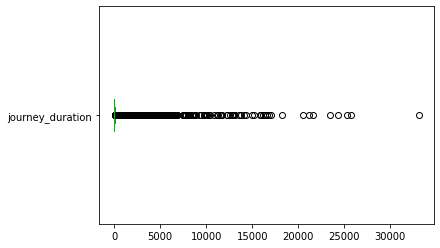

In [17]:
combined_data['journey_duration'].plot.box(vert=False)

This boxplot is not very informative because there are very large outliers that are squashing important data. This could be due many reasons, but ultimately the individuals not going to ending bike station for a long time.


In [18]:
# Removes all rows where the start date and end date are different
combined_data = combined_data.loc[combined_data['formatted_start_date'] == combined_data['formatted_end_date']]



I remove this data because I will not be able to account for the temperature on the rows that overlap into different days.

<AxesSubplot:>

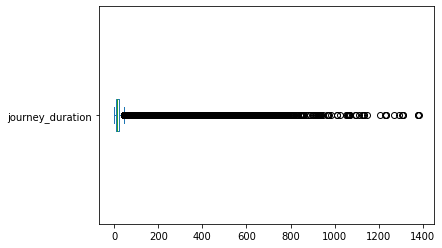

In [19]:
combined_data['journey_duration'].plot.box(vert=False)

This still yields a large number of outliers. Even with the dates accounted for, the variance is still very large. To visualize this data and explain it will be difficult. This still yields a large number of outliers. Even with the dates accounted for, the variance is still very large. To visualize this data and explain will be difficult.

In [20]:
combined_data['journey_duration'].std()

29.06431743732258

In [21]:
# Creat a data subset the data to exclude extreme values
lower_extremes = combined_data['journey_duration'].quantile(0.10)
upper_extremes = combined_data['journey_duration'].quantile(0.90)
combined_data_subset = combined_data[(combined_data['journey_duration'] > lower_extremes) & (combined_data['journey_duration'] < upper_extremes)]


I exclude the extreme values from the dataset to improve the accuracy and interpretability of the analysis and modeling if necessary. Outliers can skew the distribution and hide the more representative values in the dataset. Doing this allows me to focus on the more typical values and create visualizations that are easier to understand and produce more meaningful conclusions.

<AxesSubplot:>

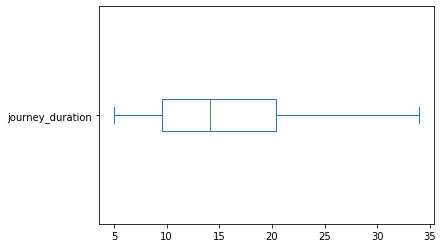

In [22]:
combined_data_subset['journey_duration'].plot.box(vert=False)

There are no outliers, so I can reap the benefits made in the last paragraph. Moreover, this column was the only column this had to be altered to this extent due to the variance. Now I can start to analyze the data.

## Analysis


### 1. Affect of Weather on journey duration 



In [23]:
# calculate correlation coefficients
corr_matrix = combined_data_subset[['journey_duration', 'prcp_(mm)', 'tavg_(celsius)']].corr()

# print the correlation coefficients
print(corr_matrix)


                  journey_duration  prcp_(mm)  tavg_(celsius)
journey_duration          1.000000  -0.014656        0.008178
prcp_(mm)                -0.014656   1.000000       -0.156034
tavg_(celsius)            0.008178  -0.156034        1.000000


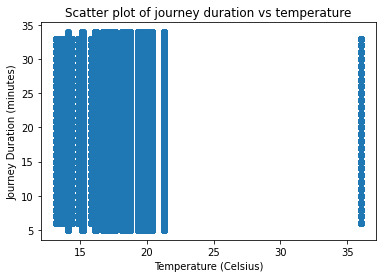

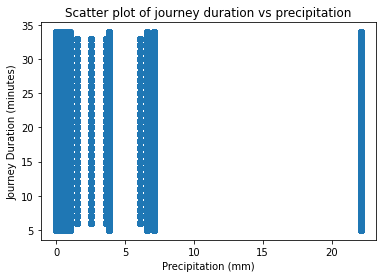

In [24]:
# Create a scatter plot of journey duration vs temperature
plt.scatter(combined_data_subset['tavg_(celsius)'], combined_data_subset['journey_duration'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Journey Duration (minutes)')
plt.title('Scatter plot of journey duration vs temperature')
plt.show()

# Create a scatter plot of journey duration vs precipitation
plt.scatter(combined_data_subset['prcp_(mm)'], combined_data_subset['journey_duration'])
plt.xlabel('Precipitation (mm)')
plt.ylabel('Journey Duration (minutes)')
plt.title('Scatter plot of journey duration vs precipitation')
plt.show()

Scatter plots like this do not provide me with any actionable information. This is because the temp and precipitation values are discrete and are not displayed on temperature for every hour, for example.

In [25]:
# Group the data by temperature and calculate the mean journey duration
mean_duration_by_temp = combined_data_subset.groupby('tavg_(celsius)')['journey_duration'].mean()

# Group the data by precipitation and calculate the mean journey duration
mean_duration_by_prcp = combined_data_subset.groupby('prcp_(mm)')['journey_duration'].mean()


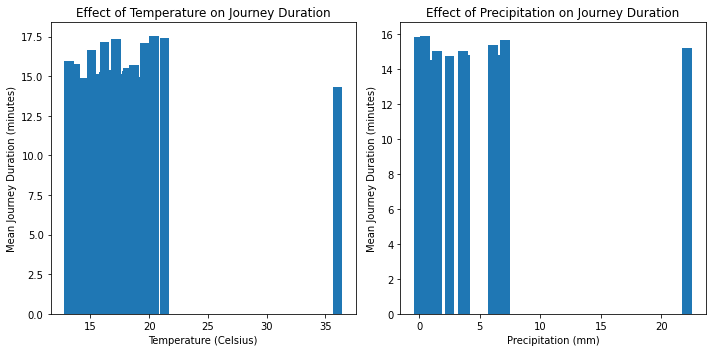

In [26]:
# Create two bar plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Bar plot for temperature
axs[0].bar(mean_duration_by_temp.index, mean_duration_by_temp.values)
axs[0].set_xlabel('Temperature (Celsius)')
axs[0].set_ylabel('Mean Journey Duration (minutes)')
axs[0].set_title('Effect of Temperature on Journey Duration')

# Bar plot for precipitation
axs[1].bar(mean_duration_by_prcp.index, mean_duration_by_prcp.values)
axs[1].set_xlabel('Precipitation (mm)')
axs[1].set_ylabel('Mean Journey Duration (minutes)')
axs[1].set_title('Effect of Precipitation on Journey Duration')

plt.tight_layout()
plt.show()

This is why i use a bar plot, because I can see that journey duration does not really affect the journey duration. Having said that, the journey duration was lowest when the temperature was higher, but that is the most significant change. 

### 1.1 Affect of Weather on cycle volume


In [27]:
# group by formatted_start_date and count the number of rows
cycle_volume = combined_data_subset.groupby('formatted_start_date').size().reset_index(name='cycle_volume')

cycle_volume.head()

,formatted_start_date,cycle_volume
0,01/08/2017,31767
1,01/09/2017,26654
2,02/08/2017,22351
3,02/09/2017,21945
4,03/08/2017,27796


In [28]:
# merge counts_by_date with combined_data on formatted_start_date
merged_data = pd.merge(cycle_volume, combined_data_subset, on='formatted_start_date')

# calculate correlation between cycle volume and tavg_(celsius)
corr_tavg = merged_data['cycle_volume'].corr(merged_data['tavg_(celsius)'])

# calculate correlation between cycle volume and prcp_(mm)
corr_prcp = merged_data['cycle_volume'].corr(merged_data['prcp_(mm)'])


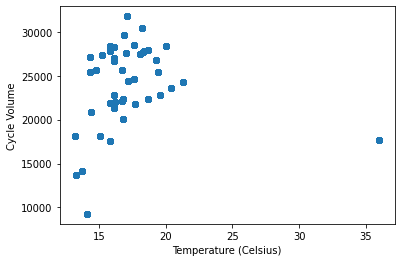

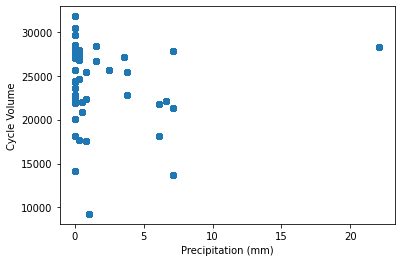

Correlation with temperature 0.026859602995678297
Correlation with precipitation -0.02680728193328157


In [29]:
# create scatter plot of counts and temperature
plt.scatter(merged_data['tavg_(celsius)'], merged_data['cycle_volume'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Cycle Volume')
plt.show()

# create scatter plot of counts and precipitation
plt.scatter(merged_data['prcp_(mm)'], merged_data['cycle_volume'])
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cycle Volume')
plt.show()

print('Correlation with temperature ' + str(corr_tavg))
print('Correlation with precipitation ' + str(corr_prcp))

In the temperature plot, we can see a small positive correlation with the day, with the highest temperature having a below average cycle volume. In the precipitation plot there is no obvious correlation.

### 2. The usefulness and performance of trying to predict cycle volumes

In [30]:
merged_data.corr()['cycle_volume']

cycle_volume        1.000000
journey_duration   -0.022098
end_station_id     -0.037242
start_station_id   -0.037362
station_id         -0.037362
capacity            0.007792
latitude            0.015978
longitude           0.006599
prcp_(mm)          -0.026807
tavg_(celsius)      0.026860
Name: cycle_volume, dtype: float64

I check this to have an idea what would be the best columns to use as in input variable for the train test split.

In [31]:
# Split the dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(merged_data[['prcp_(mm)','tavg_(celsius)','start_station_id','capacity']], merged_data['cycle_volume'], test_size=0.2, random_state=42)

In [32]:
# Train and evaluate a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg_pred = lin_reg.predict(x_test)
lin_reg_mse = mean_squared_error(y_test, lin_reg_pred)
lin_reg_r2 = r2_score(y_test, lin_reg_pred)

# Print the evaluation metrics
print('Linear Regression MSE: ', lin_reg_mse)
print('Linear Regression R2: ', lin_reg_r2)

Linear Regression MSE:  17060507.822016332
Linear Regression R2:  0.002392688274614585


MSE and R2 are both good metrics for evaluating the performance of regression models since they measure the accuracy of the predications (the lower the value, the better) and how well the model fits the data, respectively (The closer the value is to 1, the better).

Initially, linear regression was applied as it is a basic and commonly used machine learning algorithm for regression problems. The results showed that the model was not accurate enough to predict cycle volumes, so I know a more complex model will be needed.




In [33]:
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Train and evaluate a linear regression model
poly_reg = LinearRegression()
poly_reg.fit(x_train_poly, y_train)
poly_reg_pred = poly_reg.predict(x_test_poly)
poly_reg_mse = mean_squared_error(y_test, poly_reg_pred)
poly_reg_r2 = r2_score(y_test, poly_reg_pred)

print('Polynomial Regression MSE: ', poly_reg_mse)
print('Polynomial Regression R2: ', poly_reg_r2)

Polynomial Regression MSE:  12271143.34214863
Polynomial Regression R2:  0.28244912466439487


Polynomial regression was applied as it could capture non-linear relationships between the input features and the target variable. The model performed significantly better than linear regression since its scores were so low. However, these metrics are not good enough to make predications accurately.

In [34]:
# Train and evaluate a neural network regression model
nn_reg = MLPRegressor(hidden_layer_sizes=(25, 4), activation='relu', solver='adam')
nn_reg.fit(x_train, y_train)
nn_reg_pred = nn_reg.predict(x_test)
nn_reg_mse = mean_squared_error(y_test, nn_reg_pred)
nn_reg_r2 = r2_score(y_test, nn_reg_pred)

print('Neural Network Regression MSE: ', nn_reg_mse)
print('Neural Network Regression R2: ', nn_reg_r2)

Neural Network Regression MSE:  9103555.63726614
Neural Network Regression R2:  0.467672723392462


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Neural network regression was applied as it can capture complex and non-linear relationships between the input features and the target variable. The model performed better than the previous two models but still was not accurate enough to make reliable predictions. This type of model is highly configurable, so the potential of this method has not been reached yet **(THIS WILL BE TALKED ABOUT IN THE PRESENTATION)**.




In [35]:
# Train and evaluate a decision tree regression model
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train, y_train)
dt_reg_pred = dt_reg.predict(x_test)
dt_reg_mse = mean_squared_error(y_test, dt_reg_pred)
dt_reg_r2 = r2_score(y_test, dt_reg_pred)

print('Decision Tree Regression MSE: ', dt_reg_mse)
print('Decision Tree Regression R2: ', dt_reg_r2)

Decision Tree Regression MSE:  370090.83314643544
Decision Tree Regression R2:  0.9783590661543515


As for this dataset decision tree regression proved to have the lowest MSE and highest R2 score meaning it had the most predictive power. However, it is important to note that the usefulness of this model may depend on the quality and quantity of the input data. To see the full potential, more exploration is needed to observe the model's performance on a wider range of datasets.



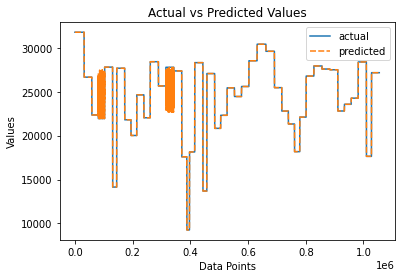

In [45]:
# Create a dataframe of actual and predicted values
df = pd.DataFrame({'actual': y_test, 'predicted': dt_reg_pred})

# Create the line plot
sns.lineplot(data=df)

# Add axis labels and a title
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')

# Show the plot
plt.show()

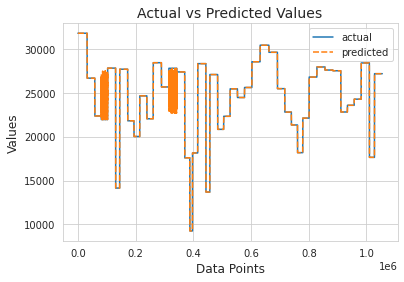

<Figure size 1728x1296 with 0 Axes>

In [47]:
# Create a dataframe of actual and predicted values
df = pd.DataFrame({'actual': y_test, 'predicted': dt_reg_pred})

# Set the style to 'whitegrid'
sns.set_style('whitegrid')

# Create the line plot
sns.lineplot(data=df)

# Add axis labels and a title
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Actual vs Predicted Values', fontsize=14)

# Increase the size of the plot
plt.figure(figsize=(24, 18))

# Show the plot
plt.show()

### 3. Where to add another station

In [38]:
# Select the relevant features for clustering
cluster_data = merged_data[['journey_duration', 'end_station_id', 'start_station_id', 'latitude', 'longitude']]

# Scaling the data
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

I scale the data since columns selected for the cluster data have different measurements and scaling it means that the input features have a similar scale and range which will lead to less biased results and improved performance.

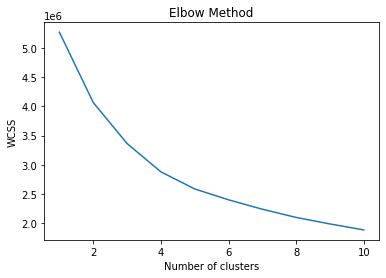

In [39]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(cluster_data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

This is an important step because it has a large influence on the accuracy and usefulness of the clustering results. Not enough clusters could oversimplify the data and too many could cause overfitting and patterns that are not useful. 

In [49]:
# Fit K-means clustering on the data for the optimal number of clusters
k = 4  # set the optimal number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(cluster_data_scaled)

# Add the cluster labels to the original dataset
merged_data['cluster'] = y_kmeans

# Identify the stations that have the highest volume of journeys in each cluster
for i in range(k):
    cluster_df = merged_data[merged_data['cluster'] == i]
    start_station_counts = cluster_df['start_station_id'].value_counts()
    end_station_counts = cluster_df['end_station_id'].value_counts()
    station_counts = start_station_counts.add(end_station_counts, fill_value=0)
    station_counts = station_counts.sort_values(ascending=False)
    print(f"Cluster {i}:\n{station_counts.head(3)}\n")

Cluster 0:
14     15254.0
154    13710.0
194     7410.0
dtype: float64

Cluster 1:
191    9695.0
248    7688.0
303    7060.0
dtype: float64

Cluster 2:
785    6993.0
732    5876.0
553    5361.0
dtype: float64

Cluster 3:
680    5142.0
737    5012.0
625    4524.0
dtype: float64



/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


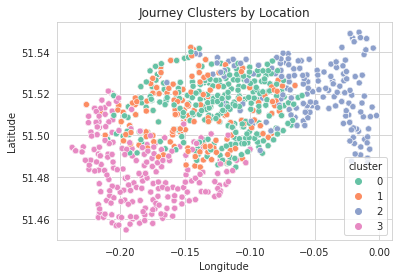

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of the clustered data
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=merged_data, palette='Set2')

# Add a title and labels for the axes
plt.title('Journey Clusters by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

The simple way is to add a station to the station that has the most volume, but I dont believe that is the best area to add a new station. Due to time constraints, I cannot fully explore the ideas for finding the most optimal station. **(THIS WILL BE TALKED ABOUT IN THE PRESENTATION)**